## Задание 1

### Текст задания:
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1 928 игроков из 202 103 оказались платящими, а в тестовой – 1 805 из 202 667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from scipy.stats import chi2_contingency
import pingouin as pg
from scipy.stats import levene
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import ttest_ind

import requests
from urllib.parse import urlencode

In [2]:
def get_data_from_Yandex_disk(url, sep):
    """ 
    Возвращает df из файла с .csv-расширением, хранящегося на Яндекс-диске,
    url - путь на Яндекс-диск,
    sep - разделитель в файле csv
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
       
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep=sep)
    return df

In [3]:
df = get_data_from_Yandex_disk('https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';')

In [4]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Цель проведения A/B-теста - улучшение целевых метрик, при сохранении необходимого уровня остальных метрик. 
Для оценки эффективности той или иной акции используется 2 группы метрик: количественные и доходные.

**Под количественными метриками** мы в данном случае можем понимать долю платящих клиентов.

**Когда речь идет о метриках, связанных с монетизацией,** обычно имеют в виду следующие: Общий доход (Revenue) и средние величины: ARPU, ARPPU, средний или медианный чеки.


Для начала проведем первичную оценку данных, проверим их на наличие выбросов и аномалий.

In [5]:
df.shape

(404770, 3)

In [6]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [8]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Разделим данные для удобства анализа на 2 группы: тестовую и контрольную, при этом оставив в выбоках только платящих пользователей, поскольку интересуют нас, в первую очередь, они.

In [9]:
df_control = df.query('testgroup == "a" and revenue > 0')

In [10]:
df_test = df.query('testgroup == "b" and revenue > 0')

Проведем анализ данных пользователей, попавших в тестовую группу

In [11]:
df_control['revenue'].describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

<AxesSubplot:>

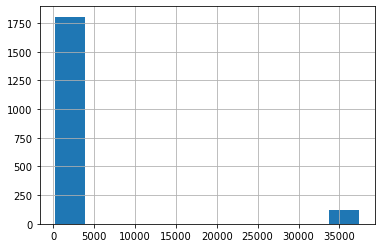

In [12]:
df_control.revenue.hist()

Удаляем выбросы из контрольной группы

In [13]:
df_control_modified = df_control.query('revenue < 30000')

In [14]:
df_control_modified['revenue'].describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

<AxesSubplot:>

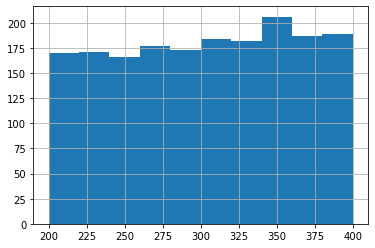

In [15]:
df_control_modified.revenue.hist()

<AxesSubplot:ylabel='revenue'>

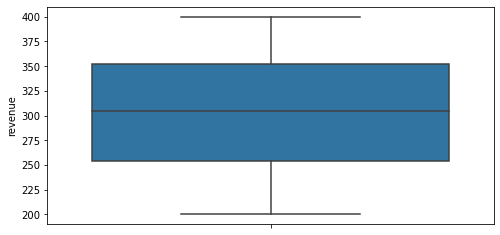

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='revenue', data=df_control_modified)

In [17]:
df_test.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


<AxesSubplot:>

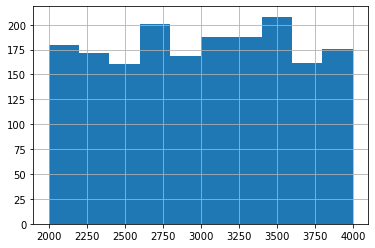

In [18]:
df_test.revenue.hist()

<AxesSubplot:ylabel='revenue'>

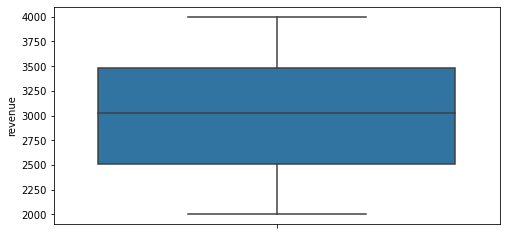

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='revenue', data=df_test)

In [20]:
data = df.query('revenue > 0 and revenue < 30000').groupby('testgroup', as_index=False).agg({'revenue': 'median'})

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

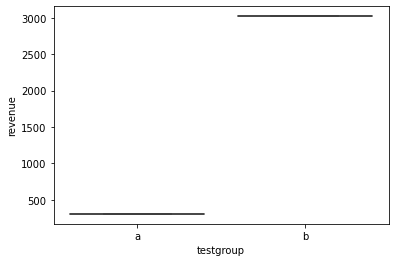

In [21]:
sns.boxplot(x='testgroup', y='revenue', data=data)

Как мы видим из боксплотов, различия между медианными значениями существенны 

In [22]:
df.query('revenue > 0 and revenue < 30000').groupby('testgroup', as_index=False).agg({'revenue': 'median'})

,testgroup,revenue
0,a,305.0
1,b,3022.0


#### Конверсия. 

С помощью критерия согласия Пирсона проверим, значимы ли различия между группами в доле платящих пользователей. **Н0 =** наблюдаемые частоты соответствуют ожидаемым
**Н1 =** наблюдаемые частоты в группах отличаются от ожидаемых. 
Для этого составим таблицу сопряженности:

In [23]:
# вычислим количество платящих пользователей
paying_customers = df.query('revenue > 0 and revenue < 30000') \
                     .groupby('testgroup', as_index=False) \
                     .agg({'user_id': 'count'})

In [24]:
# вычислим количество не платящих пользователей
non_paying_customers = df.query('revenue < 30000').groupby('testgroup', as_index=False).agg({'user_id': 'count'})

In [25]:
# составим таблицу сопряженности
df_for_analysis = non_paying_customers.merge(paying_customers, how='left', on='testgroup') \
                                      .rename(columns={'user_id_x': 'non_paying_cust', 'user_id_y': 'paying_cust'}) \
                                      .set_index('testgroup')

In [26]:
df_for_analysis

,non_paying_cust,paying_cust
testgroup,,
a,201980,1805
b,202667,1805


In [27]:
df_for_analysis.values

array([[201980,   1805],
       [202667,   1805]], dtype=int64)

**Проведем тестирование**

In [28]:
chi, pvalue, k, _ = chi2_contingency(df_for_analysis.values)

In [29]:
chi

0.007197557957172926

In [30]:
pvalue

0.9323898467843289

In [31]:
k

1

##### Вывод:
Гипотеза об однородности выборок не отвергается. Таким образом, мы можем сказать, что **в результате проведенного теста, количество платящих пользователей значимо не изменилось**

### Метрики дохода

До начала эксперимента необходимо определить объем выборки, достаточный для того, чтобы различия между метриками были статистически значимы. В данном задании ничего не говорится о том, какое изменение целевых метрик будет призначаться значимым. Т.к. в нашем случае нам целевое изменение не известно, мы можем вычислить какова чувствительность у проведенного теста, при имеющихся объемах выборок, power=0.90 и уровне значимости 5%.

In [32]:
# размер выборки контрольной группы
nx = df.query('revenue < 30000 and testgroup == "a"').shape[0]

In [33]:
# размер выборки тестовой группы
ny = df.query('revenue < 30000 and testgroup == "b"').shape[0]

In [34]:
pg.power_ttest2n(nx=nx, ny=ny, power=0.90, alpha=0.05, alternative='greater')

0.009200843580902451

**Вывод:**
При заданной мощности и объеме выборок, мы можем отследить изменения показателей менее 1%.

### ARPU

Для того, чтобы расчитать ARPU, нам нужны все данные, по платящим и неплатящим пользователям, но без выбросов, которые было решено в анализе не учитывать.

In [35]:
# Считаем ARPU без выбросов
ARPU_by_groups = df.query('revenue < 30000') \
                   .groupby('testgroup', as_index=False) \
                   .agg({'revenue': 'mean'}) \
                   .rename(columns={'revenue': 'mean'})
ARPU_by_groups

,testgroup,mean
0,a,2.702926
1,b,26.751287


In [36]:
control_group_ARPU = df.query('revenue < 30000 and testgroup == "a"').revenue

In [37]:
test_group_ARPU = df.query('revenue < 30000 and testgroup == "b"').revenue

<AxesSubplot:>

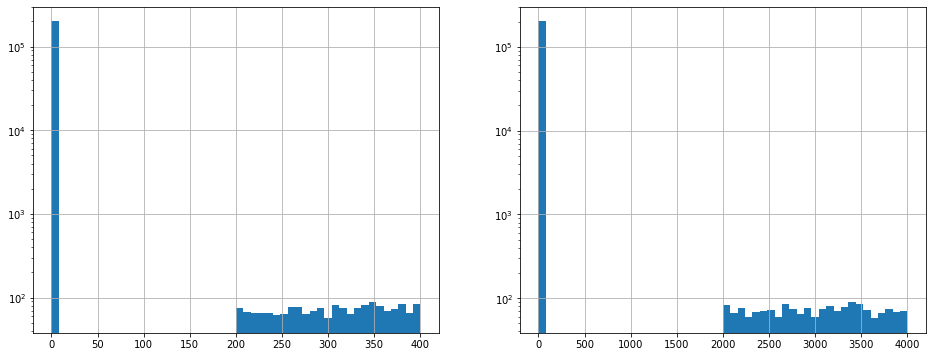

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
control_group_ARPU.hist(bins=50, log=True, ax=axes[0])
test_group_ARPU.hist(bins=50, log=True, ax=axes[1])

Т.к. ARPU фактически является средним значение в выборке, мы можем применить парный t-тест для их сравнения. Однако, его можно применять при выполнении следующих требований:
1. требование гомогенности дисперсий. Проверяем с помощью критерия Левена
2. требование к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения.

In [39]:
# Запускаем тест Левена
stat, p = levene(control_group_ARPU, test_group_ARPU)

In [40]:
p

4.912187546515184e-306

**Вывод:** Результаты теста Левина позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [41]:
# сэмплируем выборку для тестовой группы
test_sample = test_group_ARPU.sample(1000, random_state=17)

In [42]:
# Запускаем тест Шапиро_Уилка для тестовой группы
stats.shapiro(test_sample)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

In [43]:
# сэмплируем выборку для контрольной группы
control_sample = control_group_ARPU.sample(1000, random_state=17)

In [44]:
# Запускаем тест Шапиро_Уилка для контрольной группы
stats.shapiro(control_sample)

ShapiroResult(statistic=0.09302335977554321, pvalue=0.0)

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

Итак, оба условия для проведения t-теста не выполняются.
В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [45]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    test_group_ARPU,   # числовые значения первой выборки
    control_group_ARPU,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.mean,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(test_group_ARPU), len(control_group_ARPU)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = test_group_ARPU.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = control_group_ARPU.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

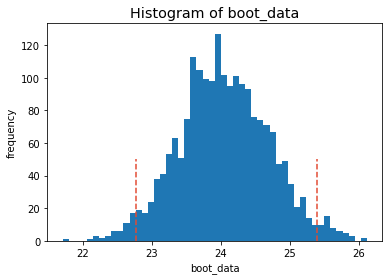

In [46]:
booted_data = get_bootstrap(test_group_ARPU, control_group_ARPU, boot_it=2000)

In [47]:
booted_data["p_value"]

4.124650336765042e-297

In [48]:
booted_data["ci"]

,0
0.025,22.767742
0.975,25.399605


##### Вывод: 
**ARPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

### ARPPU

Для того, чтобы расчитать ARPU, нам нужны данные по платящим пользователям, но без выбросов, которые было решено в анализе не учитывать.

In [49]:
ARPPU_by_groups = df.query('revenue > 0 and revenue < 30000') \
                    .groupby('testgroup', as_index=False) \
                    .agg({'revenue': 'mean'}) \
                    .rename(columns={'revenue': 'mean'})
ARPPU_by_groups

,testgroup,mean
0,a,302.458172
1,b,3003.658172


Посмотрим гистограмму распределений величин

<AxesSubplot:>

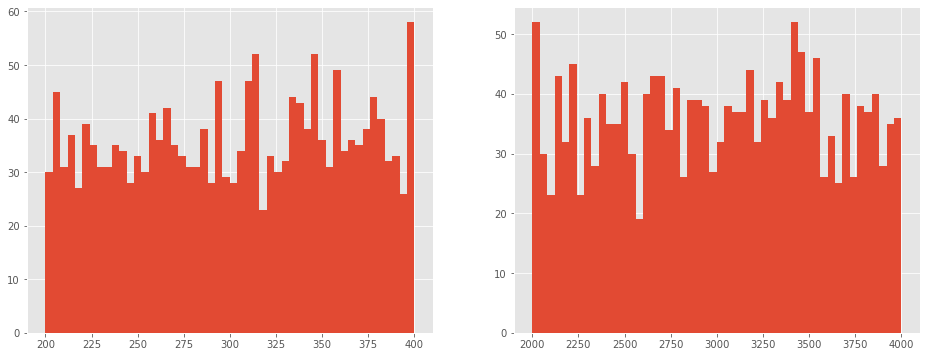

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df_control_modified.revenue.hist(bins=50, ax=axes[0])
df_test.revenue.hist(bins=50, ax=axes[1])

In [51]:
df_test.revenue

160       3797
377       3768
386       3527
551       2038
913       3902
          ... 
403843    3383
403994    2793
404161    2316
404193    2998
404525    3120
Name: revenue, Length: 1805, dtype: int64

Как мы видим, распределение не является нормальным

Т.к. ARPPU фактически является средним значение в выборке, мы можем применить аналогичный порядок действий, который применяли по отношению к ARPU.
Порядок действий:
1. проверка на соответствие требованию гомогенности дисперсий. Проверяем с помощью критерия Левена
2. проверка на соответствие требованию к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения
3. парный t-тест для сравнения, если предыдущие условия выполняются.

In [52]:
# Запускаем тест Левена
stat, p = levene(df_control_modified.revenue, df_test.revenue)

In [53]:
p

0.0

**Вывод:** Результаты теста Левина позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [54]:
# сэмплируем выборку для контрольной группы
control_sample = df_control_modified.revenue.sample(1000, random_state=17)

In [55]:
# Запускаем тест Шапиро-Уилка для контрольной группы
stats.shapiro(control_sample)

ShapiroResult(statistic=0.9577839374542236, pvalue=2.1956142196103692e-16)

In [56]:
# сэмплируем выборку для тестовой группы
test_sample = df_test.revenue.sample(1000, random_state=17)

In [57]:
# Запускаем тест Шапиро-Уилка для контрольной группы
stats.shapiro(test_sample)

ShapiroResult(statistic=0.9613319039344788, pvalue=1.2883664412895895e-15)

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [58]:
df_control_modified = df_control_modified.revenue

In [59]:
df_test = df_test.revenue

In [60]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    df_test,   # числовые значения первой выборки
    df_control_modified,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.mean,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(df_test), len(df_control_modified)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = df_test.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = df_control_modified.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

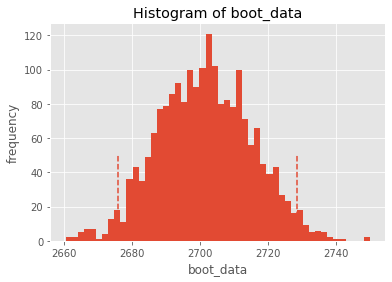

In [61]:
booted_data = get_bootstrap(df_test, df_control_modified, boot_it=2000)

In [62]:
booted_data["p_value"]

0.0

In [63]:
booted_data["ci"]

,0
0.025,2675.690388
0.975,2728.356731


**ARPPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

### Средний (медианный) чек

При анализе предоставленных данных мы могли пойти по другому пути, и рассмотреть в качестве целевой метрики рассмотреть медианный чек. При этом, мы можем не удалять их данных выбросы, т.к. в некоторых случаях они могут быть значимыми для анализа.
В этом случае, мы могли бы расчитывать только на симуляцию, для построение доверительного интервала для мединаны

In [64]:
df.groupby('testgroup', as_index=False) \
  .agg({'revenue': 'median'}) \
  .rename(columns={'revenue': 'median'})

,testgroup,median
0,a,0.0
1,b,0.0


В целом по выборке, медианное значение равно 0, поэтому уберем из данных информацию о тех пользователях, которые не совершали покупки, но оставим выбросы.

In [65]:
df_control = df.query('testgroup == "a" and revenue > 0').revenue
df_control.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [66]:
df_test = df.query('testgroup == "b" and revenue > 0').revenue
df_test.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Когда мы сравниваем траты пользователей на сервисе, то средний чек может не измениться, но может вырасти число людей, которые тратят больше определенного значения. В качестве такого значения можно взять верхний порог (3 квартиль) - 361 рубль.
Если мы посмотрим на количество людей, которые потратили суммарно 361 рубль и более, то получим следующие результаты:

In [67]:
df.query('revenue > 361') \
  .groupby('testgroup') \
  .agg({'user_id': 'count'})

,user_id
testgroup,
a,481
b,1805


In [68]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    df_control,   # числовые значения первой выборки
    df_test,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.median,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(df_control), len(df_test)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = df_control.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = df_test.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

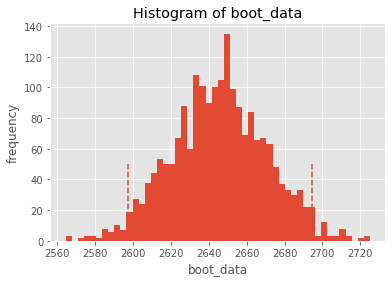

In [69]:
booted_data = get_bootstrap(df_test, df_control, boot_it=2000)

In [70]:
booted_data["p_value"]

0.0

In [71]:
booted_data["ci"]

,0
0.025,2597.5000
0.975,2694.5125


**Медианный чек** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

## Общие выводы по заданию 2

**Основные гипотезы для анализа результатов теста**

**Нулевая гипотеза.** Все наборы акционных предложений имеют одинаковые показатели платежной эффективности. Другими словами, нет эффекта или нет разницы между разными предложениями.

**Альтернативная гипотеза.** Между наборами акционных предложений есть статистически значимая разница.

### Результаты:
Показатель конверсии (CR) не различается значимо в тестовой контрольной группе. 
ARPU, ARPPU и средний (медианный) чек значимо различаются в тестовой и контрольной группе.
Исходя из этого, мы можем доверять следующим данным:
1. В тестовой группе ARPU выше в 13 раз (без учета выбросов)
2. В тестовой группе ARPPU выше в 10 раз (без учета выбросов)
3. Средний (медианный чек) также выше в 10 раз. 
Метрики дохода значительно выросли, без сокращения конверсии.

Таким образом, мы можем сделать вывод о том, что набор предложений в тестовой группе можно считать лучшим.